In [1]:
import torch
import torch.nn.functional as F
import math
import numpy as np
import argparse
from torchvision import datasets, transforms
import random
import copy
import torch.nn as nn
import sys
from torch.utils.data import random_split

In [2]:
train_size = 2000
test_size = 3000
d = 784
device = torch.device("cpu")

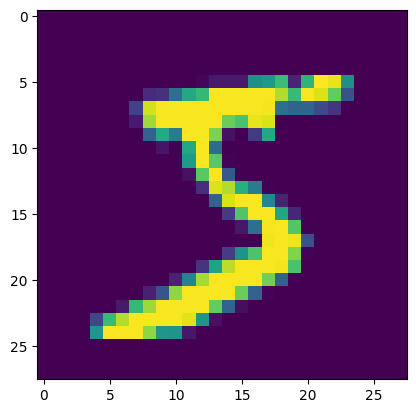

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
trainset = datasets.MNIST('MNIST', train=True, download=True,
                    transform=transform)
testset = datasets.MNIST('MNIST', train=False,
                    transform=transform)

import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])


trainset = random_split(trainset, [train_size, trainset.data.shape[0] - train_size],generator=torch.Generator().manual_seed(7))[0]
testset = random_split(testset, [test_size, testset.data.shape[0] - test_size],generator=torch.Generator().manual_seed(7))[0]

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=train_size, shuffle= False)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=test_size, shuffle= False)

In [4]:

def rff(data,rd,width):
  data = data.view(-1,784)/math.sqrt(d)
  feature = torch.mm(data,rd)
  feature = torch.cat((torch.sin(feature),torch.cos(feature)),dim = 1)
  return feature

In [5]:
widths = [10,20,50,100,200,500,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000,4000,5000,6000,8000]
train_losses = []
train_accs = []
test_losses = []
test_accs = []

In [6]:
for width in widths:
    rd = torch.normal(mean = 0,std= 1, size = (784,width//2)).to(device).double()
    for (data,target) in train_loader:
        data, target = data.to(device).double(), target.to(device)
        one_hot = nn.functional.one_hot(target,10).double()
        rff_train = rff(data,rd,width)
        print(rff_train.shape)
        if width< train_size:
            a = torch.inverse(rff_train.t()@rff_train)@rff_train.t()@one_hot
        else:
            a = rff_train.t()@torch.inverse(rff_train@rff_train.t())@one_hot
        output = rff_train@a
        train_loss = torch.norm(output - one_hot)**2/train_size
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum()
        accuracy = correct/train_size
        print(f'training loss: {train_loss}, training accuracy:{accuracy}')
        train_losses.append(train_loss)
        train_accs.append(accuracy)
    for (data_test,target_test) in test_loader:
        data_test, target_test = data_test.to(device).double(), target_test.to(device)
        one_hot_test = nn.functional.one_hot(target_test,10).double()
        rff_test = rff(data_test,rd,width)
        print(rff_test.shape)
        output_test = rff_test@a
        test_loss = torch.norm(output_test - one_hot_test)**2/test_size
        pred = output_test.argmax(dim=1, keepdim=True)
        correct = pred.eq(target_test.view_as(pred)).sum()
        accuracy = correct/test_size
        print(f'test loss: {test_loss}, test accuracy:{accuracy}')
        test_losses.append(test_loss)
        test_accs.append(accuracy)

torch.Size([2000, 10])
training loss: 0.8253438419392518, training accuracy:0.2994999885559082
torch.Size([3000, 10])
test loss: 0.8371006277328225, test accuracy:0.2770000100135803
torch.Size([2000, 20])
training loss: 0.6989181978905251, training accuracy:0.5680000185966492
torch.Size([3000, 20])
test loss: 0.7139643819951889, test accuracy:0.5263333320617676
torch.Size([2000, 50])
training loss: 0.5747260061097452, training accuracy:0.7055000066757202
torch.Size([3000, 50])
test loss: 0.5927220102726588, test accuracy:0.6813333630561829
torch.Size([2000, 100])
training loss: 0.4316243144948958, training accuracy:0.843500018119812
torch.Size([3000, 100])
test loss: 0.4642886954989333, test accuracy:0.8183333277702332
torch.Size([2000, 200])
training loss: 0.3340026185609499, training accuracy:0.9004999995231628
torch.Size([3000, 200])
test loss: 0.4005213157225874, test accuracy:0.8603333234786987
torch.Size([2000, 500])
training loss: 0.206150747232677, training accuracy:0.972500026

In [7]:
import matplotlib.pyplot as plt

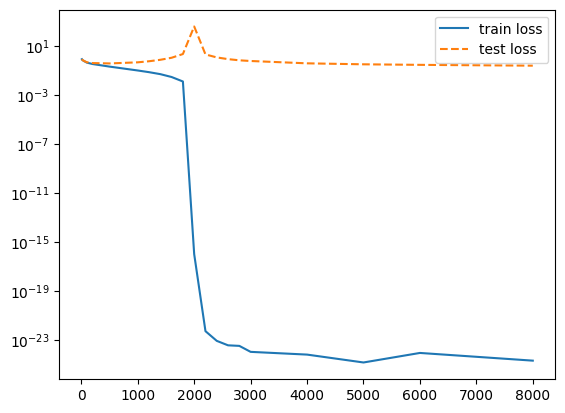

In [8]:
plt.plot(widths,train_losses,linestyle='-',label = 'train loss')
plt.plot(widths,test_losses,linestyle='--',label = 'test loss')
plt.legend()
plt.yscale('log')
plt.show()

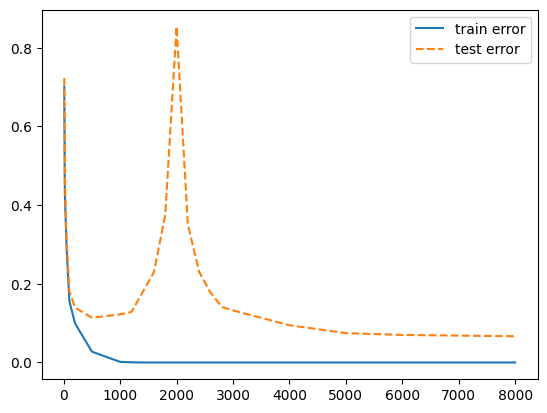

In [9]:
plt.plot(widths,1 - np.array(train_accs),linestyle='-',label = 'train error')
plt.plot(widths,1 - np.array(test_accs),linestyle='--',label = 'test error')
plt.legend()

plt.show()

In [10]:
def euclidean_distances(samples, centers, squared=True):
    '''Calculate the pointwise distance.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        squared: boolean.

    Returns:
        pointwise distances (n_sample, n_center).
    '''
    samples_norm = torch.sum(samples**2, dim=1, keepdim=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = torch.sum(centers**2, dim=1, keepdim=True)
    centers_norm = torch.reshape(centers_norm, (1, -1))

    distances = samples.mm(torch.t(centers))
    distances.mul_(-2)
    distances.add_(samples_norm)
    distances.add_(centers_norm)
    if not squared:
        distances.clamp_(min=0)
        distances.sqrt_()

    return distances


def gaussian(samples, centers, bandwidth):
    '''Gaussian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers)
    kernel_mat.clamp_(min=0)
    gamma = 1. / (2 * bandwidth ** 2)
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat

In [11]:
dis = []
for width in widths:
    rd = torch.normal(mean = 0,std= 1, size = (784,width//2)).to(device).double()
    for (data,target) in train_loader:
        data, target = data.to(device).double(), target.to(device)
        one_hot = nn.functional.one_hot(target,10).double()
        rff_train = rff(data,rd,width)
        data = data.to(device).reshape(-1,784).double()/math.sqrt(784)
        gaussian_kernel = gaussian(data,data,1)
        dis.append(torch.norm(rff_train@rff_train.t()/width*2 - gaussian_kernel)/torch.norm(gaussian_kernel).item())


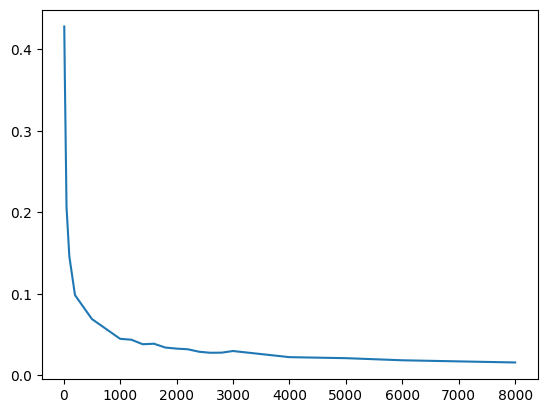

In [12]:
plt.plot(widths,dis,label = 'relative diff')
plt.show()

In [107]:
for (data,target) in train_loader:
    data, target = data.to(device).reshape(-1,784).double()/math.sqrt(784), target.to(device)
    one_hot = nn.functional.one_hot(target,10).double()
    gaussian_kernel = gaussian(data,data,1)
    a = torch.inverse(gaussian_kernel)@one_hot
    output = gaussian_kernel@a
    train_loss = torch.norm(output - one_hot)**2/train_size
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum()
    accuracy = correct/train_size
    print(f'training loss: {train_loss}, training accuracy:{accuracy}')
for (data_test,target_test) in test_loader:
    data_test, target_test = data_test.to(device).reshape(-1,784).double()/math.sqrt(784), target_test.to(device)
    one_hot_test = nn.functional.one_hot(target_test,10).double()
    gaussian_kernel_test = gaussian(data_test,data,1)
    output_test = gaussian_kernel_test@a
    test_loss = torch.norm(output_test - one_hot_test)**2/test_size
    pred = output_test.argmax(dim=1, keepdim=True)
    correct = pred.eq(target_test.view_as(pred)).sum()
    accuracy = correct/test_size
print(test_loss,accuracy)

training loss: 8.879236287173974e-25, training accuracy:1.0
tensor(0.1773, dtype=torch.float64) tensor(0.9440)


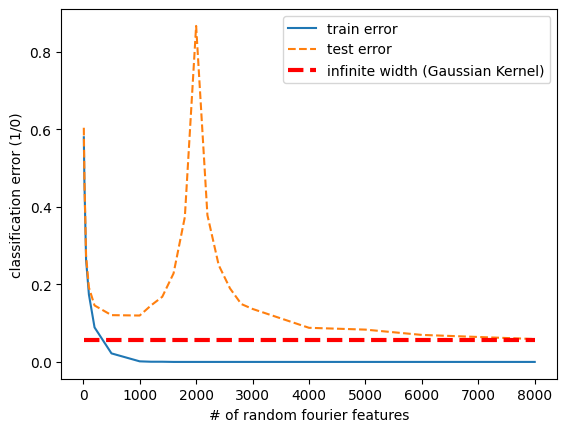

In [111]:
plt.plot(widths,1 - np.array(train_accs),linestyle='-',label = 'train error')
plt.plot(widths,1 - np.array(test_accs),linestyle='--',label = 'test error')
plt.hlines(xmin=widths[0],xmax=widths[-1],y = 1-accuracy, linewidth = 3,linestyle='--', colors='r', label = 'infinite width (Gaussian Kernel)')
plt.legend()
plt.xlabel('# of random fourier features')
plt.ylabel('classification error (1/0)')
plt.show()